In [138]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import random

In [139]:
# Setting hyperparameters
batch_size = 64
epochs = 50
learning_rate = 0.0001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
model_type = "Encoder-Decoder"

In [140]:
df = pd.read_csv("data/ac_data.csv")

df.head()

,date_time,temperature_datetime,temperature,airQuality_datetime,airQuality
0,2023-06-11 01:07:06.889863,2023-6-10-17-7-7,25.3750,2023-6-10-17-7-9,449
1,2023-06-11 01:12:07.465380,2023-6-10-17-12-4,25.3125,2023-6-10-17-12-8,461
2,2023-06-11 01:17:08.019617,2023-6-10-17-17-5,25.3125,2023-6-10-17-17-7,454
3,2023-06-11 01:22:08.641555,2023-6-10-17-22-8,25.1875,2023-6-10-17-22-9,460
4,2023-06-11 01:27:09.215907,2023-6-10-17-27-5,25.0625,2023-6-10-17-27-7,482


In [141]:
# Generating dataset

class device_data(Dataset):
    def __init__(self, X, window, horizon=0):
        self.X = []
        self.y = []
        self.len = X.shape[0]-window-1
        for i in range(0, len(X)-window-1-horizon):
            self.X.append(X[i:window+i])
            self.y.append(X[window+i: window+i+horizon+1])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return torch.Tensor(self.X[index]), torch.Tensor([self.y[index]])

In [142]:
scaler = MinMaxScaler()
scaler.fit(df["temperature"].to_numpy().reshape(-1, 1))
data = scaler.transform(df["temperature"].to_numpy().reshape(-1, 1))

In [143]:
# data = df["temperature"].to_numpy()

In [144]:
# Sequence lenght is 12. 1 hr duration
window = 12
horizon = 4

In [145]:
train = device_data(data.squeeze()[:800], window, horizon)
val = device_data(data.squeeze()[800:900], window, horizon)
test = device_data(data.squeeze()[900:], window, horizon)

In [146]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [147]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([64, 12]) torch.Size([64, 1, 5])


In [148]:
class Encoder(nn.Module):
    def __init__(self, seq_len, input_shape, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden = hidden_size
        self.input_shape = input_shape
        self.gru = nn.GRU(input_shape, hidden_size, num_layers, batch_first=True)

    def forward(self, input):
        # input [batch, window]
        # hidden = torch.zeros([self.num_layers, self.hidden]).cuda()
        # hidden = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
        output, hidden = self.gru(input)
        return output, hidden

In [149]:
# Test encoder model,
input_shape = 1
enc_test = Encoder(window, input_shape, hidden_shape, num_layers=num_layer).cuda()
# (seq,btch,in_sh)
out, h = enc_test(features.unsqueeze(2).cuda())
print(out.shape, h.shape)

torch.Size([64, 12, 64]) torch.Size([1, 64, 64])


In [150]:
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(1, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        # print(input.dtype, hidden.dtype)
        output, hidden = self.gru(input, hidden)
        output = self.linear(output)
        return output, hidden

In [151]:
output_size = 1
dec_test = Decoder(output_size, hidden_shape, num_layers=num_layer).cuda()
# h = torch.zeros([dec_test.num_layers, dec_test.hidden])
labels = labels.permute(0, 2, 1)
out, h = dec_test(labels[:, 0].view(batch_size, 1, 1).cuda(), h)
print(out.shape, h.shape)

torch.Size([64, 1, 1]) torch.Size([1, 64, 64])


In [152]:
input_shape = 1
encoder = Encoder(window, input_shape, hidden_shape, num_layers=num_layer).cuda()

output_size = 1
decoder = Decoder(output_size, hidden_shape, num_layers=num_layer).cuda()

In [153]:
criterion = nn.MSELoss()
rnn_model_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(rnn_model_params, lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:1, train loss: [0.4147732631924252], val loss: [0.0293864111105601]


c:\Users\siddp\OneDrive\Desktop\project-venv\dryice\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:2, train loss: [0.3860256237288316], val loss: [0.027121280630429585]
Epoch:3, train loss: [0.35846182284876704], val loss: [0.02493918438752492]
Epoch:4, train loss: [0.3317145736267169], val loss: [0.022810230652491253]
Epoch:5, train loss: [0.30538992762255174], val loss: [0.020704027265310287]
Epoch:6, train loss: [0.27911828361296404], val loss: [0.018594011664390564]
Epoch:7, train loss: [0.2525876148138195], val loss: [0.016460036238034565]
Epoch:8, train loss: [0.2255669265675048], val loss: [0.014289836088816324]
Epoch:9, train loss: [0.19792662444524467], val loss: [0.012082502245903015]
Epoch:10, train loss: [0.1697061664890498], val loss: [0.009857608626286188]
Epoch:11, train loss: [0.14125969532566765], val loss: [0.007671215881903966]
Epoch:12, train loss: [0.11348917715561886], val loss: [0.005638588219881058]
Epoch:13, train loss: [0.08813487373602887], val loss: [0.003952658424774806]
Epoch:14, train loss: [0.06783153217596312], val loss: [0.0028462295110026994]

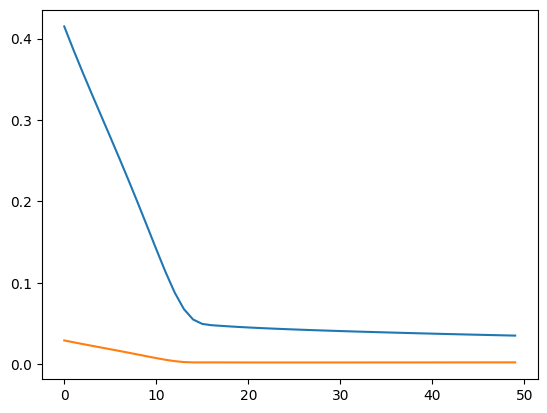

In [154]:
loss_train = []
loss_val = []
for i in range(epochs):
    total_loss = 0
    total_val = 0
    n_batch = 0
    for batch_x, batch_y in train_loader:
        n_batch += 1
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.unsqueeze(2)
        batch_y = batch_y.permute(0, 2, 1)
        optimizer.zero_grad()
        encoder_output, encoder_hidden = encoder(batch_x)
        dec_input = batch_y[:, 0].view(batch_size, 1, 1)
        dec_hidden = encoder_hidden
        mse_train = 0
        for t in range(1, batch_y.size(1)):
            predictions, dec_hidden = decoder(dec_input, dec_hidden)
            mse_train_step = criterion(batch_y[:, t], predictions)
            mse_train += mse_train_step
            dec_input = batch_y[:, t].view(batch_size, 1, 1)

        batch_loss = mse_train / (batch_y.size(1) - 1)
        total_loss += batch_loss.item()

        batch_loss.backward()
        optimizer.step()
        # if lr_decay:
            # epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_x = batch_x.unsqueeze(2)
            batch_y = batch_y.permute(0, 2, 1)
            optimizer.zero_grad()
            encoder_output, encoder_hidden = encoder(batch_x)
            dec_input = batch_y[:, 0].view(batch_size, 1, 1)
            dec_hidden = encoder_hidden
            mse_val = 0
            for t in range(1, batch_y.size(1)):
                predictions, dec_hidden = decoder(dec_input, dec_hidden)
                mse_val_step = criterion(batch_y[:, t], predictions)
                mse_val += mse_val_step
                dec_input = batch_y[:, t].view(batch_size, 1, 1)

            batch_loss = mse_val / (batch_y.size(1) - 1)
            total_val += batch_loss.item()   

        # if n_batch % 100 == 0:
        #     print(f"Iteration:{n_batch}, Loss: {[batch_loss.item()]}")    

    print(f"Epoch:{i+1}, train loss: {[total_loss/n_batch]}, val loss: {[total_val/n_batch]}")
    loss_train.append(total_loss/n_batch)
    loss_val.append(total_val/n_batch)

plt.plot(loss_train)
plt.plot(loss_val)
plt.show()       

In [155]:
print(len(test_loader))
print(test.__len__())

132
132


In [156]:
with torch.no_grad():
  preds = []
  true = []
  for i, (batch_x, batch_y) in enumerate(test_loader):
        # print(i)
        if i == 127:
            break
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.unsqueeze(2)
        batch_y = batch_y.permute(0, 2, 1)
        temp = batch_y.squeeze(dim=2)
        # print(f'the true values: {temp}')
        if i == 0:
            true.extend(temp.detach().cpu().numpy())
        else:
            true.append(temp[0, -1].detach().cpu().numpy())   
        encoder_output, encoder_hidden = encoder(batch_x)
        dec_input = batch_y[:, 0].view(1, 1, 1)
        if i == 0:
            temp = dec_input.detach().cpu().numpy()
            # print(f'the 1st pred value: {temp.reshape(1, -1)}')
            preds.append(temp.reshape(1, -1))

        dec_hidden = encoder_hidden
        l = []
        for t in range(1, batch_y.size(1)):
            predictions, dec_hidden = decoder(dec_input, dec_hidden)
            best_guess = predictions.detach().cpu().numpy()
            # print(f'the {t+1}st pred value: {best_guess}')
            if i == 0:
                preds.append(best_guess.reshape(1, -1))
            else:
                l.append(best_guess)    
            dec_input = predictions.view(1, 1, 1)
        if i != 0:
            preds.append(l[-1].reshape(1, -1))    

preds = np.concatenate(preds)
true = np.concatenate([np.atleast_1d(arr) for arr in true])
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

print(mse, mae)

0.028169675 0.13265595


In [157]:
preds = scaler.inverse_transform(preds)
true = scaler.inverse_transform(true.reshape(-1, 1))

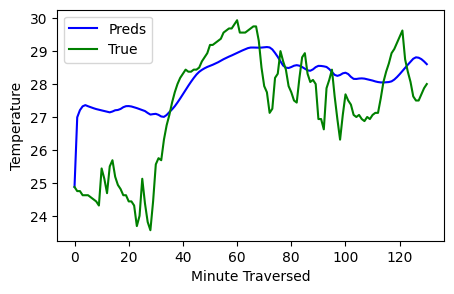

In [160]:
plt.figure(figsize=(5, 3))
plt.plot(preds, 'b', label='Preds')
plt.plot(true, 'g', label='True')
plt.legend()
plt.xlabel("Minute Traversed")
plt.ylabel("Temperature")
plt.show()

In [159]:
# Creating/updating config file with hyperparameters and model performance
import os
from pathlib import Path
import json

filepath = "config/config.json"
filepath = Path(filepath)
filedir, filename = os.path.split(filepath)

dic = {
    "model": model_type,
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "hidden_shape": hidden_shape,
    "num_layer": num_layer,
    "l1": l1,
    "l2": l2,
    "lr_decay": lr_decay,
    "MAE": str(mae),
    "MSE": str(mse),
    "window_size": str(window),
    "horizon": str(horizon)
}

# Serializing json
json_object = json.dumps(dic, indent=4)

try:
    with open(filepath, "r") as file:
        existing_data = json.load(file)
        existing_data.append(json_object)
        with open(filepath, "w") as file:
            json.dump(existing_data, file, indent=None)
        print("New configuration for the model added")
except FileNotFoundError:
    if filedir != "":
        os.makedirs(filedir, exist_ok=True)
        print(f"Creating directory:{filedir} for the file {filename}")

    existing_data = []
    existing_data.append(json_object)
    with open(filepath, "w") as file:
        json.dump(existing_data, file, indent=None)

    print("New config file is created with first configuration for the model")

New configuration for the model added
